In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader, IterableDataset

np.random.seed(0)
torch.manual_seed(0)

使用Encoder-Decoder解决单词翻译问题：
神经网络以单个字符为标记单位进行输入输出。
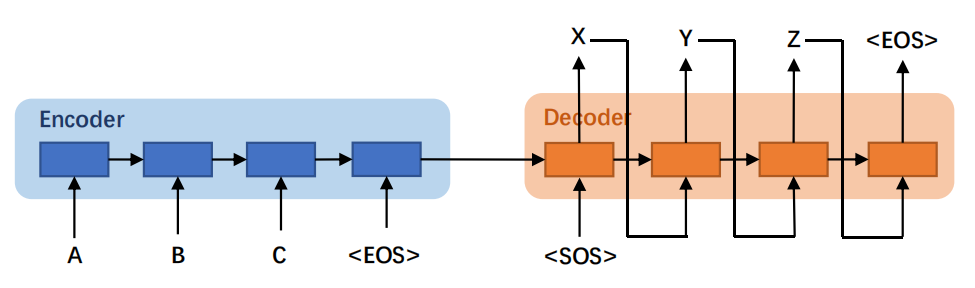
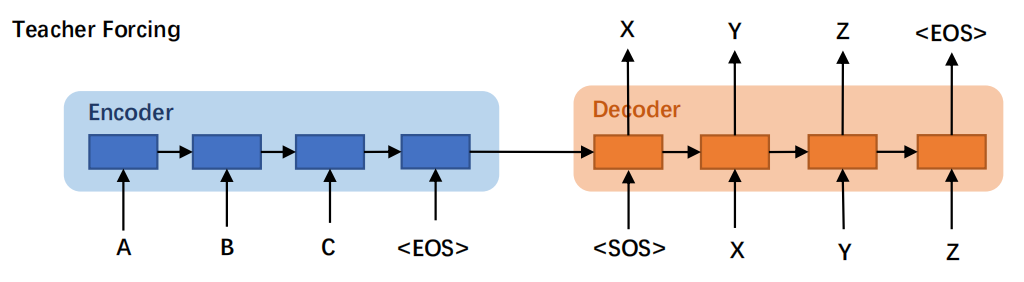

**符号定义**

In [2]:
characters = "abcdefghijklmnopqrstuvwxyz"
sign_list  = list(characters)
sign_list.append("SOS") # 开始符
sign_list.append("EOS") # 结束符
sign_list.append("PAD") # 补全符
sign_map = {value : key for key, value in enumerate(sign_list)}
num_map  = {key   : value for key, value in enumerate(sign_list)}
sign_num = len(sign_map)
print(sign_map)
print(num_map)

{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24, 'z': 25, 'SOS': 26, 'EOS': 27, 'PAD': 28}
{0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'j', 10: 'k', 11: 'l', 12: 'm', 13: 'n', 14: 'o', 15: 'p', 16: 'q', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v', 22: 'w', 23: 'x', 24: 'y', 25: 'z', 26: 'SOS', 27: 'EOS', 28: 'PAD'}


**数据生成器**

In [3]:
translation = [('man', 'women'), ('king', 'queen'), ('up', 'down'), ('high', 'low'), ("young", "old"), ("good", "bad"), ("god", "dog")]

# 最大长度用于判断测试阶段的最大解码次数
max_word_length = max([len(word) for pair in translation for word in pair])

def data_iter(batch_size, data):
    data_num = len(data)
    
    # 随机排列
    permutation = np.arange(data_num)
    np.random.shuffle(permutation)
    permutation = permutation.tolist()
    # 每次取 batch_size 个
    for index in range(0, data_num, batch_size):
        # 每个 batch 的下标
        indices = permutation[index:index+batch_size]
        
        # 由于每个batch的维度必须相同，所以我们要求出这个batch的最大长度，然后对短的序列做补全
        i_max_num, o_max_num = 0, 0
        for indice in indices:
            i_max_num = max(i_max_num, len(data[indice][0]))
            o_max_num = max(o_max_num, len(data[indice][1]))
        
        # 对每个数据进行补全、转数字后，集中起来
        encoder_input, decoder_input, target = [], [], []
        for indice in indices:
            i, o = data[indice]
            
            # 数字化
            i = [sign_map[sign] for sign in i]
            o = [sign_map[sign] for sign in o]
            
            # 补全
            i += [sign_map["PAD"] for _ in range(i_max_num - len(i))]
            o += [sign_map["PAD"] for _ in range(o_max_num - len(o))]
            
            encoder_input.append(i + [sign_map["EOS"]])
            decoder_input.append([sign_map["SOS"]] + o)
            target.append(o + [sign_map["EOS"]])
        
        # 转换为one-hot
        encoder_input = F.one_hot(torch.tensor(encoder_input), sign_num).float()
        decoder_input = F.one_hot(torch.tensor(decoder_input), sign_num).float()
#         target        = F.one_hot(torch.tensor(target), sign_num).float()
        target = torch.tensor(target)
        
        # 改为seq first的tensor，转置前两维
        encoder_input.transpose_(0, 1)
        decoder_input.transpose_(0, 1)
        target.transpose_(0, 1)
        
        yield encoder_input, decoder_input, target
                                      
for _ in range(1):
    for data in data_iter(3, translation):
        print(data[2].reshape(-1))


tensor([ 3,  3, 16, 14, 14, 20,  6, 22,  4, 28, 13,  4, 28, 28, 13, 27, 27, 27])
tensor([11, 22,  1, 14, 14,  0, 22, 12,  3, 28,  4, 28, 28, 13, 28, 27, 27, 27])
tensor([14, 11,  3, 27])


**编码器-解码器定义**  
为简单起见，循环单元只使用LSTM  
编码器：  
一个LSTM  
解码器：  
一个LSTM，一个输出层  

In [4]:
Encoder = nn.LSTM(input_size=sign_num, hidden_size=10, bias=False)

class Decoder_class(nn.Module):
    def __init__(self):
        super().__init__()
        
        # layers
        self.Decoder = nn.LSTM(input_size=sign_num, hidden_size=10, bias=False)
        self.Decoder_output_layer = nn.Linear(in_features=10, out_features=sign_num, bias=False)
    
    # 解码器需要输入初始的隐藏层
    # 在Teacher Forcing模式下，用法与普通RNN无异
    # 在自己解码的模式下，我们需要执行（序列长度）次的forward，所以，我们需要返回hidden作为下一次的输入
    def forward(self, input, hidden):
        output, hidden = self.Decoder(input, hidden)
        output = self.Decoder_output_layer(output)
        
        return output, hidden
    
Decoder = Decoder_class()
        
        

**训练阶段**


In [5]:
# 训练阶段
epoch_num  = 10000
batch_size = 3
learning_rate = 1e-4

# 生成优化器
Encoder_optimizer = optim.SGD(Encoder.parameters(), lr=learning_rate)
Decoder_optimizer = optim.SGD(Decoder.parameters(), lr=learning_rate)

for epoch in range(epoch_num):
    for ENCODER_INPUT, DECODER_INPUT, TARGET in data_iter(batch_size, translation):
        # 编码阶段
        _, context = Encoder(ENCODER_INPUT)

        # 解码阶段
        teacher_forcing = np.random.rand() > 0.5
        
        if teacher_forcing:
            # 有信号解码与普通RNN的工作方式一致
            output, hidden = Decoder(DECODER_INPUT, context)
            Loss = F.cross_entropy(output.reshape(-1, sign_num), TARGET.reshape(-1))
        else:
            # 初始化开始输入batch[SOS]
            seq_length = TARGET.size(0)# 序列长度与TARGET一致
            first_batch = torch.tensor([sign_map["SOS"]] * TARGET.size(1))
            input = F.one_hot(first_batch, sign_num).float()
            hidden = context
            Loss = 0
            # 对于次输出，选择最大的one-hot作为下次输入
            for i in range(seq_length):
                output, hidden = Decoder(input.unsqueeze(0), hidden)
                output.squeeze_(0)
                Loss += F.cross_entropy(output, TARGET[i])
                input = F.one_hot(torch.argmax(output, dim=1), sign_num).float()
        
        # 反传
        Loss.backward()
        
        # 更新
        Encoder_optimizer.step()
        Decoder_optimizer.step()
        
    if epoch % 2000 == 0:
        print(" for epoch %d\t\t, Loss is %s" % (epoch, Loss.item()))
        if Loss.item() < 0.1:
            break

 for epoch 0		, Loss is 3.3536596298217773
 for epoch 2000		, Loss is 3.358886957168579
 for epoch 4000		, Loss is 0.013728205114603043


**解码测试**

In [6]:
for pair in translation:
    print("%s:" % pair[0] , end=" ")
    
    # 输入编码
    ENCODER_INPUT = torch.tensor([sign_map[sign] for sign in pair[0]] + [sign_map["EOS"]])
    ENCODER_INPUT = F.one_hot(ENCODER_INPUT, sign_num).float() # 转换为one-hot
    ENCODER_INPUT.unsqueeze_(1) # 由于模型要接收 seq * batch * sign_num，此时batch长度是1
    
    # 编码器
    _, context = Encoder(ENCODER_INPUT)
    
    # 解码器
    # 初始化开始输入batch[SOS]
    first_batch = torch.tensor([sign_map["SOS"]])
    input = F.one_hot(first_batch, sign_num).float()
    hidden = context
    # 对于次输出，选择最大的one-hot作为下次输入
    for _ in range(max_word_length):
        output, hidden = Decoder(input.unsqueeze(0), hidden)
        output.squeeze_(0)
        sign_list = torch.argmax(output, dim=1)
        input = F.one_hot(sign_list, sign_num).float()
        
        sign = sign_list.squeeze(0)
        if sign == sign_map["EOS"]:
            break
        else:
            print(num_map[sign.item()], end="")
    
    print("")

man: women
king: queen
up: down
high: lowPADPAD
young: oldPADPAD
good: bad
god: dogPADPAD
